<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    npr Mini-Challenge 1: <br>BERTweet
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Jan Zwicky im HS 2023.
</p>

## Modellerklärung

BERT ist ein ursprünglich von Google entwickeltes Model welche für das Vortrainieren von Transformer-basierten NLP-Modellen. BERT steht für Bidirectional Encoder Representation of Transformers. BERT besteht aus aus dem linken Teil (Encoder-Teil) eines Transformers. BERT ist bidirektional, weil es aufgrund des Multi-Head-Attention den Kontext zu den vorherigen und nachfolgenden Wörter berücksichtigt (im Vergleich zum Masked-Multi-Head-Attention welcher nur die vorherigen Tokens berücksichtigt).

BERT eignet sich für diverse Aufgaben:
- Textklassifizierung (unsere Aufgabe)
- Question Answering
- Named Entity Recognition
- Text Summarization
- Language Translation
- Text Similarity

BERT eignet sich aber nicht um Texte zu generieren, da es keine Decoder-Komponente besitzt.

BERT wird auf einem grossen Korpus von Texten vortrainiert. Damit "versteht" es die Sprache und kann anschliessend auf einer spezifischen AUfgabe fein-getuned werden. 

In diesem Notebook verwenden wir BERTweet, ein BERT Modell welches speziell auf englischen Tweets von twitter.com vortrainiert wurde.

Um genau zusein, basiert BERTweet nicht auf BERT sondern RoBERTa. RoBERTa wurde auf mehr Daten trainiert als BERT und auch viel länger. Des Weiteren wurde das Maskingpattern dynamisch generiert, d.h. es wurde nicht immer das gleiche Wort maskiert.


## Requirements, Imports und Einstellungen
Hier werden die benötigten Python-Pakete importiert und die Einstellungen für die Plots
vorgenommen. 

In [1]:
# All Imports
import sys
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import datasets
from datasets import Dataset

# Versions of the packages used
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {plt.matplotlib.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")
print(f"Seaborn Version: {sns.__version__}")
print(f"Transformers Version: {transformers.__version__}")
print(f"Datasets Version: {datasets.__version__}")
print(f"Evalute Version: {evaluate.__version__}")

# Warnings Settings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Numpy Settings
np.set_printoptions(precision=2, suppress=True)
np.random.seed(42)

# Matplotlib Settings
plt.rcParams["figure.figsize"] = (24, 12)

d:\dev\npr-mc1-text-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python Version: 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
PyTorch Version: 2.1.0+cu118
Numpy Version: 1.26.0
Pandas Version: 2.1.1
Matplotlib Version: 3.8.0
Sklearn Version: 1.3.1
Seaborn Version: 0.12.2
Transformers Version: 4.34.0
Datasets Version: 2.14.5
Evalute Version: 0.4.0


## Helper Functions

Hier werden Funktionen definiert, die bei beiden Modellen verwendet werden.

In [2]:
# Metrics, shortcuts, constants, etc.
DEBUG = False

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels)["f1"],
    }

## Einlesen des Verarbeiteten Datensatzes

In [3]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [4]:
datasets = {
    "train": pd.read_csv("./data/processed/train.csv",index_col="id"),
    "val": pd.read_csv("./data/processed/val.csv",index_col="id"),
    "test": pd.read_csv("./data/raw/test.csv",index_col="id"),
}

In [5]:
for key in datasets.keys():
    datasets[key] = Dataset.from_pandas(datasets[key].rename(columns={"target":"label"})) \
        .map(tokenize_function, batched=True)
    if DEBUG:
        datasets[key] = datasets[key].shuffle(42).select(range(3))

Map: 100%|██████████| 3263/3263 [00:01<00:00, 3070.90 examples/s]


## Klassifikationsmodell

In [6]:
bertweet = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
training_args = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  num_train_epochs=50,
                                  logging_steps=500)

trainer = Trainer(
    model=bertweet,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["val"],
    compute_metrics=compute_metrics,
)

In [8]:
trainer.train()

                                                   
  2%|▏         | 188/9400 [01:16<43:47,  3.51it/s]

{'eval_loss': 0.43773508071899414, 'eval_accuracy': 0.8196392785571143, 'eval_f1': 0.7801302931596091, 'eval_runtime': 5.4156, 'eval_samples_per_second': 276.424, 'eval_steps_per_second': 8.679, 'epoch': 1.0}


                                                    
  4%|▍         | 376/9400 [02:28<41:38,  3.61it/s]

{'eval_loss': 0.40174493193626404, 'eval_accuracy': 0.8309953239812959, 'eval_f1': 0.7900414937759337, 'eval_runtime': 5.4583, 'eval_samples_per_second': 274.26, 'eval_steps_per_second': 8.611, 'epoch': 2.0}


  5%|▌         | 500/9400 [03:12<52:47,  2.81it/s]  

{'loss': 0.3745, 'learning_rate': 4.734042553191489e-05, 'epoch': 2.66}


                                                    
  6%|▌         | 564/9400 [03:41<52:10,  2.82it/s]

{'eval_loss': 0.5176470875740051, 'eval_accuracy': 0.8149632598530394, 'eval_f1': 0.7712634186622626, 'eval_runtime': 5.4418, 'eval_samples_per_second': 275.094, 'eval_steps_per_second': 8.637, 'epoch': 3.0}


                                                    
  8%|▊         | 752/9400 [04:54<40:30,  3.56it/s]

{'eval_loss': 0.49680620431900024, 'eval_accuracy': 0.8249832999331997, 'eval_f1': 0.7618181818181818, 'eval_runtime': 5.5701, 'eval_samples_per_second': 268.759, 'eval_steps_per_second': 8.438, 'epoch': 4.0}


                                                    
 10%|█         | 940/9400 [06:06<39:27,  3.57it/s]

{'eval_loss': 0.6619739532470703, 'eval_accuracy': 0.7969271877087508, 'eval_f1': 0.775480059084195, 'eval_runtime': 5.4898, 'eval_samples_per_second': 272.689, 'eval_steps_per_second': 8.561, 'epoch': 5.0}


 11%|█         | 1000/9400 [06:28<50:04,  2.80it/s] 

{'loss': 0.1819, 'learning_rate': 4.468085106382979e-05, 'epoch': 5.32}


                                                     
 12%|█▏        | 1128/9400 [07:20<48:59,  2.81it/s]

{'eval_loss': 0.6351549625396729, 'eval_accuracy': 0.832999331997328, 'eval_f1': 0.7906197654941374, 'eval_runtime': 5.4367, 'eval_samples_per_second': 275.35, 'eval_steps_per_second': 8.645, 'epoch': 6.0}


                                                     
 14%|█▍        | 1316/9400 [08:33<48:22,  2.78it/s]

{'eval_loss': 0.9416219592094421, 'eval_accuracy': 0.7835671342685371, 'eval_f1': 0.7631578947368423, 'eval_runtime': 5.4886, 'eval_samples_per_second': 272.745, 'eval_steps_per_second': 8.563, 'epoch': 7.0}


 16%|█▌        | 1500/9400 [09:38<48:57,  2.69it/s]  

{'loss': 0.1027, 'learning_rate': 4.2021276595744684e-05, 'epoch': 7.98}


                                                     
 16%|█▌        | 1504/9400 [09:47<1:26:32,  1.52it/s]

{'eval_loss': 0.8389880061149597, 'eval_accuracy': 0.8122912491649966, 'eval_f1': 0.7823392718822618, 'eval_runtime': 5.526, 'eval_samples_per_second': 270.9, 'eval_steps_per_second': 8.505, 'epoch': 8.0}


                                                     
 18%|█▊        | 1692/9400 [10:59<45:44,  2.81it/s]

{'eval_loss': 1.2036060094833374, 'eval_accuracy': 0.7862391449565799, 'eval_f1': 0.7657393850658858, 'eval_runtime': 5.4966, 'eval_samples_per_second': 272.349, 'eval_steps_per_second': 8.551, 'epoch': 9.0}


                                                     
 20%|██        | 1880/9400 [12:11<44:42,  2.80it/s]

{'eval_loss': 1.135934829711914, 'eval_accuracy': 0.802939211756847, 'eval_f1': 0.7780285929270129, 'eval_runtime': 5.4563, 'eval_samples_per_second': 274.362, 'eval_steps_per_second': 8.614, 'epoch': 10.0}


 21%|██▏       | 2000/9400 [12:54<43:50,  2.81it/s]  

{'loss': 0.0628, 'learning_rate': 3.936170212765958e-05, 'epoch': 10.64}


                                                     
 22%|██▏       | 2068/9400 [13:25<42:59,  2.84it/s]

{'eval_loss': 0.9385707378387451, 'eval_accuracy': 0.8203072812291249, 'eval_f1': 0.7883556254917388, 'eval_runtime': 5.4248, 'eval_samples_per_second': 275.953, 'eval_steps_per_second': 8.664, 'epoch': 11.0}


                                                     
 24%|██▍       | 2256/9400 [14:37<32:52,  3.62it/s]

{'eval_loss': 1.085838794708252, 'eval_accuracy': 0.8162992651970608, 'eval_f1': 0.7889485801995396, 'eval_runtime': 5.417, 'eval_samples_per_second': 276.355, 'eval_steps_per_second': 8.676, 'epoch': 12.0}


                                                     
 26%|██▌       | 2444/9400 [15:49<41:16,  2.81it/s]

{'eval_loss': 1.2528883218765259, 'eval_accuracy': 0.8096192384769539, 'eval_f1': 0.7835990888382688, 'eval_runtime': 5.4756, 'eval_samples_per_second': 273.396, 'eval_steps_per_second': 8.584, 'epoch': 13.0}


 27%|██▋       | 2500/9400 [16:09<41:13,  2.79it/s]  

{'loss': 0.042, 'learning_rate': 3.670212765957447e-05, 'epoch': 13.3}


                                                     
 28%|██▊       | 2632/9400 [17:03<39:55,  2.83it/s]

{'eval_loss': 1.066699504852295, 'eval_accuracy': 0.8129592518370073, 'eval_f1': 0.7836166924265843, 'eval_runtime': 5.7242, 'eval_samples_per_second': 261.522, 'eval_steps_per_second': 8.211, 'epoch': 14.0}


                                                     
 30%|███       | 2820/9400 [18:17<38:52,  2.82it/s]

{'eval_loss': 1.1420292854309082, 'eval_accuracy': 0.8069472277889111, 'eval_f1': 0.7761425251742836, 'eval_runtime': 7.5538, 'eval_samples_per_second': 198.178, 'eval_steps_per_second': 6.222, 'epoch': 15.0}


 32%|███▏      | 3000/9400 [19:21<38:07,  2.80it/s]  

{'loss': 0.0323, 'learning_rate': 3.4042553191489365e-05, 'epoch': 15.96}


                                                     
 32%|███▏      | 3008/9400 [19:31<33:50,  3.15it/s]

{'eval_loss': 1.3202236890792847, 'eval_accuracy': 0.7989311957247829, 'eval_f1': 0.777859778597786, 'eval_runtime': 5.4592, 'eval_samples_per_second': 274.215, 'eval_steps_per_second': 8.609, 'epoch': 16.0}


                                                     
 34%|███▍      | 3196/9400 [20:43<36:42,  2.82it/s]

{'eval_loss': 1.313351035118103, 'eval_accuracy': 0.8129592518370073, 'eval_f1': 0.7859327217125383, 'eval_runtime': 5.5149, 'eval_samples_per_second': 271.447, 'eval_steps_per_second': 8.522, 'epoch': 17.0}


                                                     
 36%|███▌      | 3384/9400 [21:55<35:48,  2.80it/s]

{'eval_loss': 1.3819880485534668, 'eval_accuracy': 0.8149632598530394, 'eval_f1': 0.785769528228925, 'eval_runtime': 5.4645, 'eval_samples_per_second': 273.952, 'eval_steps_per_second': 8.601, 'epoch': 18.0}


 37%|███▋      | 3500/9400 [22:37<35:05,  2.80it/s]  

{'loss': 0.0154, 'learning_rate': 3.1382978723404254e-05, 'epoch': 18.62}


                                                     
 38%|███▊      | 3572/9400 [23:09<26:57,  3.60it/s]

{'eval_loss': 1.3753385543823242, 'eval_accuracy': 0.8216432865731463, 'eval_f1': 0.7743026204564667, 'eval_runtime': 5.4328, 'eval_samples_per_second': 275.547, 'eval_steps_per_second': 8.651, 'epoch': 19.0}


                                                     
 40%|████      | 3760/9400 [24:22<33:16,  2.83it/s]

{'eval_loss': 1.4533660411834717, 'eval_accuracy': 0.7949231796927188, 'eval_f1': 0.7734317343173432, 'eval_runtime': 5.4299, 'eval_samples_per_second': 275.693, 'eval_steps_per_second': 8.656, 'epoch': 20.0}


                                                     
 42%|████▏     | 3948/9400 [25:34<25:24,  3.58it/s]

{'eval_loss': 1.475365161895752, 'eval_accuracy': 0.8096192384769539, 'eval_f1': 0.7799227799227799, 'eval_runtime': 5.4257, 'eval_samples_per_second': 275.911, 'eval_steps_per_second': 8.663, 'epoch': 21.0}


 43%|████▎     | 4000/9400 [25:52<32:21,  2.78it/s]  

{'loss': 0.013, 'learning_rate': 2.8723404255319154e-05, 'epoch': 21.28}


                                                     
 44%|████▍     | 4136/9400 [26:48<31:06,  2.82it/s]

{'eval_loss': 1.5448464155197144, 'eval_accuracy': 0.8076152304609219, 'eval_f1': 0.7735849056603773, 'eval_runtime': 5.4476, 'eval_samples_per_second': 274.799, 'eval_steps_per_second': 8.628, 'epoch': 22.0}


                                                     
 46%|████▌     | 4324/9400 [28:02<29:53,  2.83it/s]

{'eval_loss': 1.366154432296753, 'eval_accuracy': 0.8102872411489646, 'eval_f1': 0.7784711388455537, 'eval_runtime': 7.3944, 'eval_samples_per_second': 202.45, 'eval_steps_per_second': 6.356, 'epoch': 23.0}


 48%|████▊     | 4500/9400 [29:05<28:50,  2.83it/s]  

{'loss': 0.0096, 'learning_rate': 2.6063829787234046e-05, 'epoch': 23.94}


                                                     
 48%|████▊     | 4512/9400 [29:17<23:44,  3.43it/s]

{'eval_loss': 1.4192990064620972, 'eval_accuracy': 0.8196392785571143, 'eval_f1': 0.7794117647058824, 'eval_runtime': 5.4367, 'eval_samples_per_second': 275.35, 'eval_steps_per_second': 8.645, 'epoch': 24.0}


                                                     
 50%|█████     | 4700/9400 [30:29<27:28,  2.85it/s]

{'eval_loss': 1.6135892868041992, 'eval_accuracy': 0.8069472277889111, 'eval_f1': 0.778544061302682, 'eval_runtime': 5.4244, 'eval_samples_per_second': 275.976, 'eval_steps_per_second': 8.665, 'epoch': 25.0}


                                                     
 52%|█████▏    | 4888/9400 [31:41<26:21,  2.85it/s]

{'eval_loss': 1.8004883527755737, 'eval_accuracy': 0.7962591850367402, 'eval_f1': 0.775570272259014, 'eval_runtime': 5.4327, 'eval_samples_per_second': 275.554, 'eval_steps_per_second': 8.651, 'epoch': 26.0}


 53%|█████▎    | 5000/9400 [32:21<26:18,  2.79it/s]  

{'loss': 0.0086, 'learning_rate': 2.340425531914894e-05, 'epoch': 26.6}


                                                     
 54%|█████▍    | 5076/9400 [32:55<20:04,  3.59it/s]

{'eval_loss': 1.4515981674194336, 'eval_accuracy': 0.7955911823647295, 'eval_f1': 0.771641791044776, 'eval_runtime': 5.4288, 'eval_samples_per_second': 275.751, 'eval_steps_per_second': 8.658, 'epoch': 27.0}


                                                     
 56%|█████▌    | 5264/9400 [34:07<24:37,  2.80it/s]

{'eval_loss': 1.6176331043243408, 'eval_accuracy': 0.8082832331329325, 'eval_f1': 0.7817490494296577, 'eval_runtime': 5.4059, 'eval_samples_per_second': 276.918, 'eval_steps_per_second': 8.694, 'epoch': 28.0}


                                                     
 58%|█████▊    | 5452/9400 [35:19<23:23,  2.81it/s]

{'eval_loss': 1.555142879486084, 'eval_accuracy': 0.8156312625250501, 'eval_f1': 0.780952380952381, 'eval_runtime': 5.4023, 'eval_samples_per_second': 277.103, 'eval_steps_per_second': 8.7, 'epoch': 29.0}


 59%|█████▊    | 5500/9400 [35:36<23:19,  2.79it/s]  

{'loss': 0.0066, 'learning_rate': 2.074468085106383e-05, 'epoch': 29.26}


                                                   
 60%|██████    | 5640/9400 [36:33<22:19,  2.81it/s]

{'eval_loss': 1.5359755754470825, 'eval_accuracy': 0.8216432865731463, 'eval_f1': 0.7869114126097367, 'eval_runtime': 5.4034, 'eval_samples_per_second': 277.046, 'eval_steps_per_second': 8.698, 'epoch': 30.0}


                                                     
 62%|██████▏   | 5828/9400 [37:46<21:04,  2.82it/s]

{'eval_loss': 1.7349950075149536, 'eval_accuracy': 0.8069472277889111, 'eval_f1': 0.778544061302682, 'eval_runtime': 5.4166, 'eval_samples_per_second': 276.375, 'eval_steps_per_second': 8.677, 'epoch': 31.0}


 64%|██████▍   | 6000/9400 [38:47<20:15,  2.80it/s]  

{'loss': 0.0053, 'learning_rate': 1.8085106382978724e-05, 'epoch': 31.91}


                                                   
 64%|██████▍   | 6016/9400 [39:00<20:28,  2.75it/s]

{'eval_loss': 1.497610092163086, 'eval_accuracy': 0.8129592518370073, 'eval_f1': 0.7802197802197802, 'eval_runtime': 5.411, 'eval_samples_per_second': 276.658, 'eval_steps_per_second': 8.686, 'epoch': 32.0}


                                                     
 66%|██████▌   | 6204/9400 [40:12<14:48,  3.60it/s]

{'eval_loss': 1.5857845544815063, 'eval_accuracy': 0.8263193052772211, 'eval_f1': 0.7868852459016393, 'eval_runtime': 5.4186, 'eval_samples_per_second': 276.273, 'eval_steps_per_second': 8.674, 'epoch': 33.0}


                                                     
 68%|██████▊   | 6392/9400 [41:24<17:55,  2.80it/s]

{'eval_loss': 1.6212904453277588, 'eval_accuracy': 0.822311289245157, 'eval_f1': 0.7726495726495726, 'eval_runtime': 5.4124, 'eval_samples_per_second': 276.588, 'eval_steps_per_second': 8.684, 'epoch': 34.0}


 69%|██████▉   | 6500/9400 [42:03<17:05,  2.83it/s]  

{'loss': 0.0021, 'learning_rate': 1.5425531914893617e-05, 'epoch': 34.57}


                                                   
 70%|███████   | 6580/9400 [42:38<13:05,  3.59it/s]

{'eval_loss': 1.7086830139160156, 'eval_accuracy': 0.8142952571810287, 'eval_f1': 0.7800632911392406, 'eval_runtime': 5.4094, 'eval_samples_per_second': 276.741, 'eval_steps_per_second': 8.689, 'epoch': 35.0}


                                                     
 72%|███████▏  | 6768/9400 [43:51<15:44,  2.79it/s]

{'eval_loss': 1.8542182445526123, 'eval_accuracy': 0.8056112224448898, 'eval_f1': 0.7749419953596288, 'eval_runtime': 5.4, 'eval_samples_per_second': 277.225, 'eval_steps_per_second': 8.704, 'epoch': 36.0}


                                                     
 74%|███████▍  | 6956/9400 [45:03<11:17,  3.61it/s]

{'eval_loss': 1.8466637134552002, 'eval_accuracy': 0.8062792251169004, 'eval_f1': 0.7772657450076805, 'eval_runtime': 5.4162, 'eval_samples_per_second': 276.392, 'eval_steps_per_second': 8.678, 'epoch': 37.0}


 74%|███████▍  | 7000/9400 [45:19<14:16,  2.80it/s]  

{'loss': 0.0013, 'learning_rate': 1.2765957446808511e-05, 'epoch': 37.23}


                                                   
 76%|███████▌  | 7144/9400 [46:17<10:26,  3.60it/s]

{'eval_loss': 1.7918380498886108, 'eval_accuracy': 0.8016032064128257, 'eval_f1': 0.7727620504973222, 'eval_runtime': 5.4344, 'eval_samples_per_second': 275.468, 'eval_steps_per_second': 8.649, 'epoch': 38.0}


                                                     
 78%|███████▊  | 7332/9400 [47:30<12:18,  2.80it/s]

{'eval_loss': 1.8143937587738037, 'eval_accuracy': 0.8136272545090181, 'eval_f1': 0.7815191855912295, 'eval_runtime': 5.4157, 'eval_samples_per_second': 276.419, 'eval_steps_per_second': 8.678, 'epoch': 39.0}


 80%|███████▉  | 7500/9400 [48:30<11:19,  2.80it/s]

{'loss': 0.0034, 'learning_rate': 1.0106382978723404e-05, 'epoch': 39.89}


                                                   
 80%|████████  | 7520/9400 [48:44<11:11,  2.80it/s]

{'eval_loss': 1.6768733263015747, 'eval_accuracy': 0.8109552438209753, 'eval_f1': 0.7804499612102406, 'eval_runtime': 5.4166, 'eval_samples_per_second': 276.374, 'eval_steps_per_second': 8.677, 'epoch': 40.0}


                                                   
 82%|████████▏ | 7708/9400 [49:56<10:02,  2.81it/s]

{'eval_loss': 1.658961534500122, 'eval_accuracy': 0.8209752839011356, 'eval_f1': 0.7883096366508688, 'eval_runtime': 5.4224, 'eval_samples_per_second': 276.076, 'eval_steps_per_second': 8.668, 'epoch': 41.0}


                                                   
 84%|████████▍ | 7896/9400 [51:08<08:56,  2.80it/s]

{'eval_loss': 1.6430761814117432, 'eval_accuracy': 0.824315297261189, 'eval_f1': 0.7788057190916736, 'eval_runtime': 5.408, 'eval_samples_per_second': 276.814, 'eval_steps_per_second': 8.691, 'epoch': 42.0}


 85%|████████▌ | 8000/9400 [51:46<08:23,  2.78it/s]

{'loss': 0.0037, 'learning_rate': 7.446808510638298e-06, 'epoch': 42.55}


                                                   
 86%|████████▌ | 8084/9400 [52:22<07:46,  2.82it/s]

{'eval_loss': 1.7063803672790527, 'eval_accuracy': 0.8236472945891784, 'eval_f1': 0.7931034482758621, 'eval_runtime': 5.4165, 'eval_samples_per_second': 276.379, 'eval_steps_per_second': 8.677, 'epoch': 43.0}


                                                   
 88%|████████▊ | 8272/9400 [53:35<06:38,  2.83it/s]

{'eval_loss': 1.7520884275436401, 'eval_accuracy': 0.822311289245157, 'eval_f1': 0.7918622848200314, 'eval_runtime': 5.4047, 'eval_samples_per_second': 276.981, 'eval_steps_per_second': 8.696, 'epoch': 44.0}


                                                   
 90%|█████████ | 8460/9400 [54:47<05:36,  2.80it/s]

{'eval_loss': 1.7302299737930298, 'eval_accuracy': 0.822311289245157, 'eval_f1': 0.7905511811023622, 'eval_runtime': 5.4281, 'eval_samples_per_second': 275.788, 'eval_steps_per_second': 8.659, 'epoch': 45.0}


 90%|█████████ | 8500/9400 [55:02<05:21,  2.80it/s]

{'loss': 0.0006, 'learning_rate': 4.787234042553191e-06, 'epoch': 45.21}


                                                   
 92%|█████████▏| 8648/9400 [56:01<04:28,  2.80it/s]

{'eval_loss': 1.746814250946045, 'eval_accuracy': 0.8229792919171677, 'eval_f1': 0.7908445146014207, 'eval_runtime': 5.405, 'eval_samples_per_second': 276.968, 'eval_steps_per_second': 8.696, 'epoch': 46.0}


                                                   
 94%|█████████▍| 8836/9400 [57:14<03:20,  2.82it/s]

{'eval_loss': 1.7568402290344238, 'eval_accuracy': 0.8236472945891784, 'eval_f1': 0.7911392405063291, 'eval_runtime': 5.4159, 'eval_samples_per_second': 276.41, 'eval_steps_per_second': 8.678, 'epoch': 47.0}


 96%|█████████▌| 9000/9400 [58:12<02:22,  2.81it/s]

{'loss': 0.0, 'learning_rate': 2.1276595744680853e-06, 'epoch': 47.87}


                                                   
 96%|█████████▌| 9024/9400 [58:28<01:45,  3.55it/s]

{'eval_loss': 1.762562870979309, 'eval_accuracy': 0.8256513026052105, 'eval_f1': 0.7930214115781127, 'eval_runtime': 5.4238, 'eval_samples_per_second': 276.006, 'eval_steps_per_second': 8.666, 'epoch': 48.0}


                                                   
 98%|█████████▊| 9212/9400 [59:40<00:52,  3.60it/s]

{'eval_loss': 1.8127720355987549, 'eval_accuracy': 0.8209752839011356, 'eval_f1': 0.7909516380655227, 'eval_runtime': 5.4153, 'eval_samples_per_second': 276.44, 'eval_steps_per_second': 8.679, 'epoch': 49.0}


                                                     
100%|██████████| 9400/9400 [1:00:53<00:00,  2.57it/s]

{'eval_loss': 1.818026065826416, 'eval_accuracy': 0.8216432865731463, 'eval_f1': 0.7918939984411535, 'eval_runtime': 5.4122, 'eval_samples_per_second': 276.597, 'eval_steps_per_second': 8.684, 'epoch': 50.0}
{'train_runtime': 3653.0594, 'train_samples_per_second': 81.959, 'train_steps_per_second': 2.573, 'train_loss': 0.04608813749348863, 'epoch': 50.0}


TrainOutput(global_step=9400, training_loss=0.04608813749348863, metrics={'train_runtime': 3653.0594, 'train_samples_per_second': 81.959, 'train_steps_per_second': 2.573, 'train_loss': 0.04608813749348863, 'epoch': 50.0})

In [9]:
history_df = pd.DataFrame(trainer.state.log_history)
history_df = history_df[history_df["train_runtime"].isna()]
history_df = history_df.dropna(axis=1, how="all")
history_df = history_df.drop(columns=["step"])

eval_df = history_df[history_df["eval_loss"].notna()]
train_df = history_df[history_df["loss"].notna()]

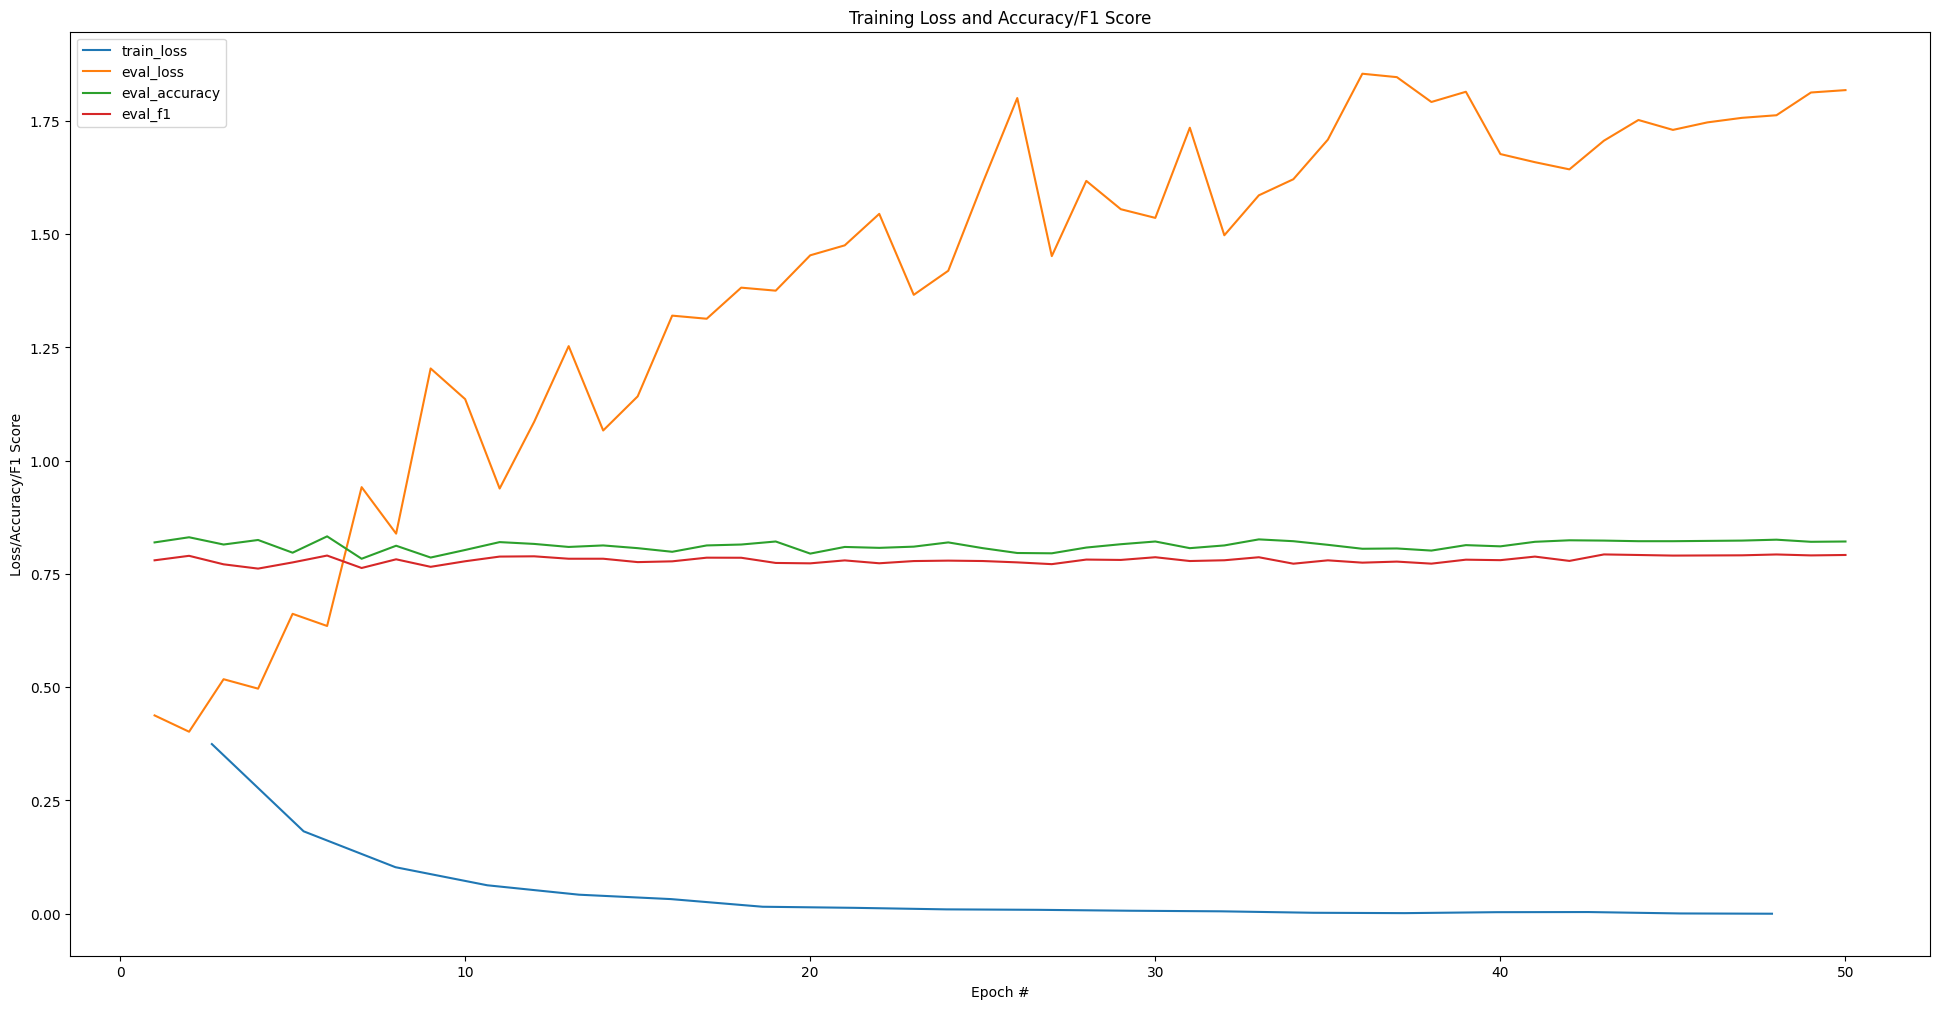

In [10]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
ax.set_title("Training Loss and Accuracy/F1 Score")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy/F1 Score")
ax.plot(train_df["epoch"], train_df["loss"], label="train_loss")
ax.plot(eval_df["epoch"], eval_df["eval_loss"], label="eval_loss")
ax.plot(eval_df["epoch"], eval_df["eval_accuracy"], label="eval_accuracy")
ax.plot(eval_df["epoch"], eval_df["eval_f1"], label="eval_f1")
ax.legend()
plt.show()

### Auswertung des Modells

In [11]:
# evaluate
trainer.evaluate()

100%|██████████| 47/47 [00:05<00:00,  9.02it/s]


{'eval_loss': 1.818026065826416,
 'eval_accuracy': 0.8216432865731463,
 'eval_f1': 0.7918939984411535,
 'eval_runtime': 5.3358,
 'eval_samples_per_second': 280.557,
 'eval_steps_per_second': 8.808,
 'epoch': 50.0}

100%|██████████| 47/47 [00:05<00:00,  8.99it/s]


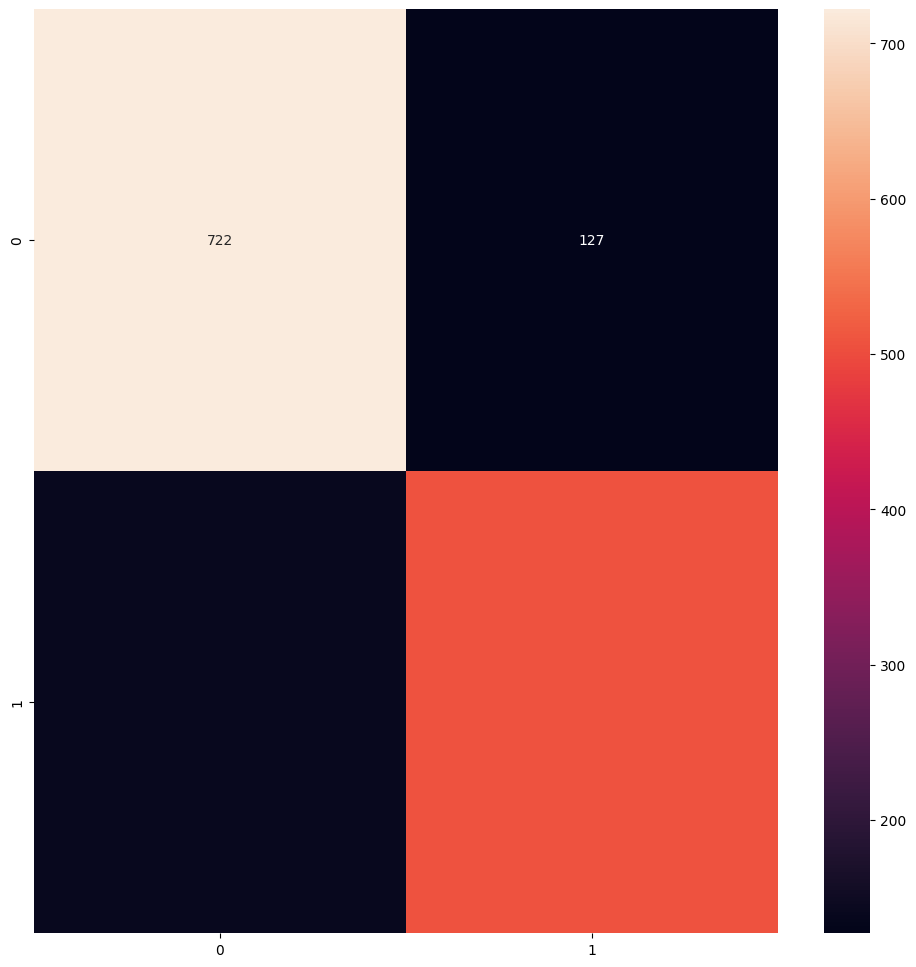

In [12]:
preds = trainer.predict(datasets["val"])
truth = preds.label_ids
preds = np.argmax(preds.predictions, axis=-1)
preds

# confusion matrix
cm = sklearn.metrics.confusion_matrix(truth, preds)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()


In [13]:
preds = trainer.predict(datasets["test"])
preds = np.argmax(preds.predictions, axis=-1)
preds


100%|██████████| 102/102 [00:11<00:00,  8.93it/s]


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

## Evaluation
In der Evaluation beschreiben wir, welche Metrik verwendet wurde, wieso die Metrik für den Anwendungsfall passt und diskutieren die Ergebnisse der Experimente und einige Vorhersagen auf einzelnen Testsamples.

## Erkenntnisse

## Fazit